In [1]:
from data_io import load_tiff_files, save_tiff_file

from sklearn.model_selection import train_test_split
from matplotlib import font_manager
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
random_seed = 256
patient_meta_df = pd.read_csv('data/patient_meta.csv')

# Step 1: Extract case ID and nerve count
case_counts = patient_meta_df[['tma_case', 'nerve_count']].copy()

# Step 2: Categorize cases based on nerve count
threshold = 2
case_counts['case_type'] = np.where(
    case_counts['nerve_count'].map(case_counts['nerve_count'].value_counts()) <= threshold, 'rare', 'frequent')
rare_cases = case_counts[case_counts['case_type'] == 'rare']
frequent_cases = case_counts[case_counts['case_type'] == 'frequent']

# Step 3: Split frequent cases into train, validation, and test sets
train_val_frequent, test_frequent = train_test_split(frequent_cases, test_size=0.1, random_state=random_seed,
                                                     stratify=frequent_cases['nerve_count'])
train_frequent, val_frequent = train_test_split(train_val_frequent, test_size=0.1 / 0.9, random_state=random_seed,
                                                stratify=train_val_frequent['nerve_count'])

# Step 4: Manually split rare cases into train, validation, and test sets
train_rare, val_rare, test_rare = np.split(rare_cases.sample(frac=1, random_state=random_seed),
                                           [int(0.8 * len(rare_cases)), int(0.9 * len(rare_cases))])

# Step 5: Merge case IDs for train, validation, and test sets
train_case_ids = np.concatenate([train_frequent['tma_case'], train_rare['tma_case']])
val_case_ids = np.concatenate([val_frequent['tma_case'], val_rare['tma_case']])
test_case_ids = np.concatenate([test_frequent['tma_case'], test_rare['tma_case']])

In [3]:
bin_nerve_mask = load_tiff_files("data/bin_nerve_mask")
peripherin_marker = load_tiff_files("data/peripherin_marker")


def partition_data(case_ids, data):
    return {case_id: data[case_id] for case_id in case_ids}


datasets = {
    "train": {
        "bin_nerve_mask": partition_data(train_case_ids, bin_nerve_mask),
        "peripherin_marker": partition_data(train_case_ids, peripherin_marker)
    },
    "val": {
        "bin_nerve_mask": partition_data(val_case_ids, bin_nerve_mask),
        "peripherin_marker": partition_data(val_case_ids, peripherin_marker)
    },
    "test": {
        "bin_nerve_mask": partition_data(test_case_ids, bin_nerve_mask),
        "peripherin_marker": partition_data(test_case_ids, peripherin_marker)
    }
}

In [4]:
# # Save the datasets
# for split, data_dict in datasets.items():
#     for data_type, data in data_dict.items():
#         output_dir = f'data/datasets/{split}/{data_type}'
#         for case_id, content in data.items():
#             save_tiff_file(output_dir, case_id, content)
#             print(f"Saved {case_id} to {output_dir}")

In [5]:
# Load the bin_nerve_mask files to get the case IDs
train_case_ids = load_tiff_files("data/datasets/train/bin_nerve_mask").keys()
val_case_ids = load_tiff_files("data/datasets/val/bin_nerve_mask").keys()
test_case_ids = load_tiff_files("data/datasets/test/bin_nerve_mask").keys()

In [6]:
len(train_case_ids), len(val_case_ids), len(test_case_ids)

(341, 43, 43)

In [7]:
# Grouping case IDs by their respective datasets
full_counts = case_counts['nerve_count'].value_counts()
train_counts = case_counts[case_counts['tma_case'].isin(train_case_ids)]['nerve_count'].value_counts()
val_counts = case_counts[case_counts['tma_case'].isin(val_case_ids)]['nerve_count'].value_counts()
test_counts = case_counts[case_counts['tma_case'].isin(test_case_ids)]['nerve_count'].value_counts()

# Plotting bar plots for each dataset
dataset_names = {
    "Full": full_counts,
    "Train": train_counts,
    "Validation": val_counts,
    "Test": test_counts
}

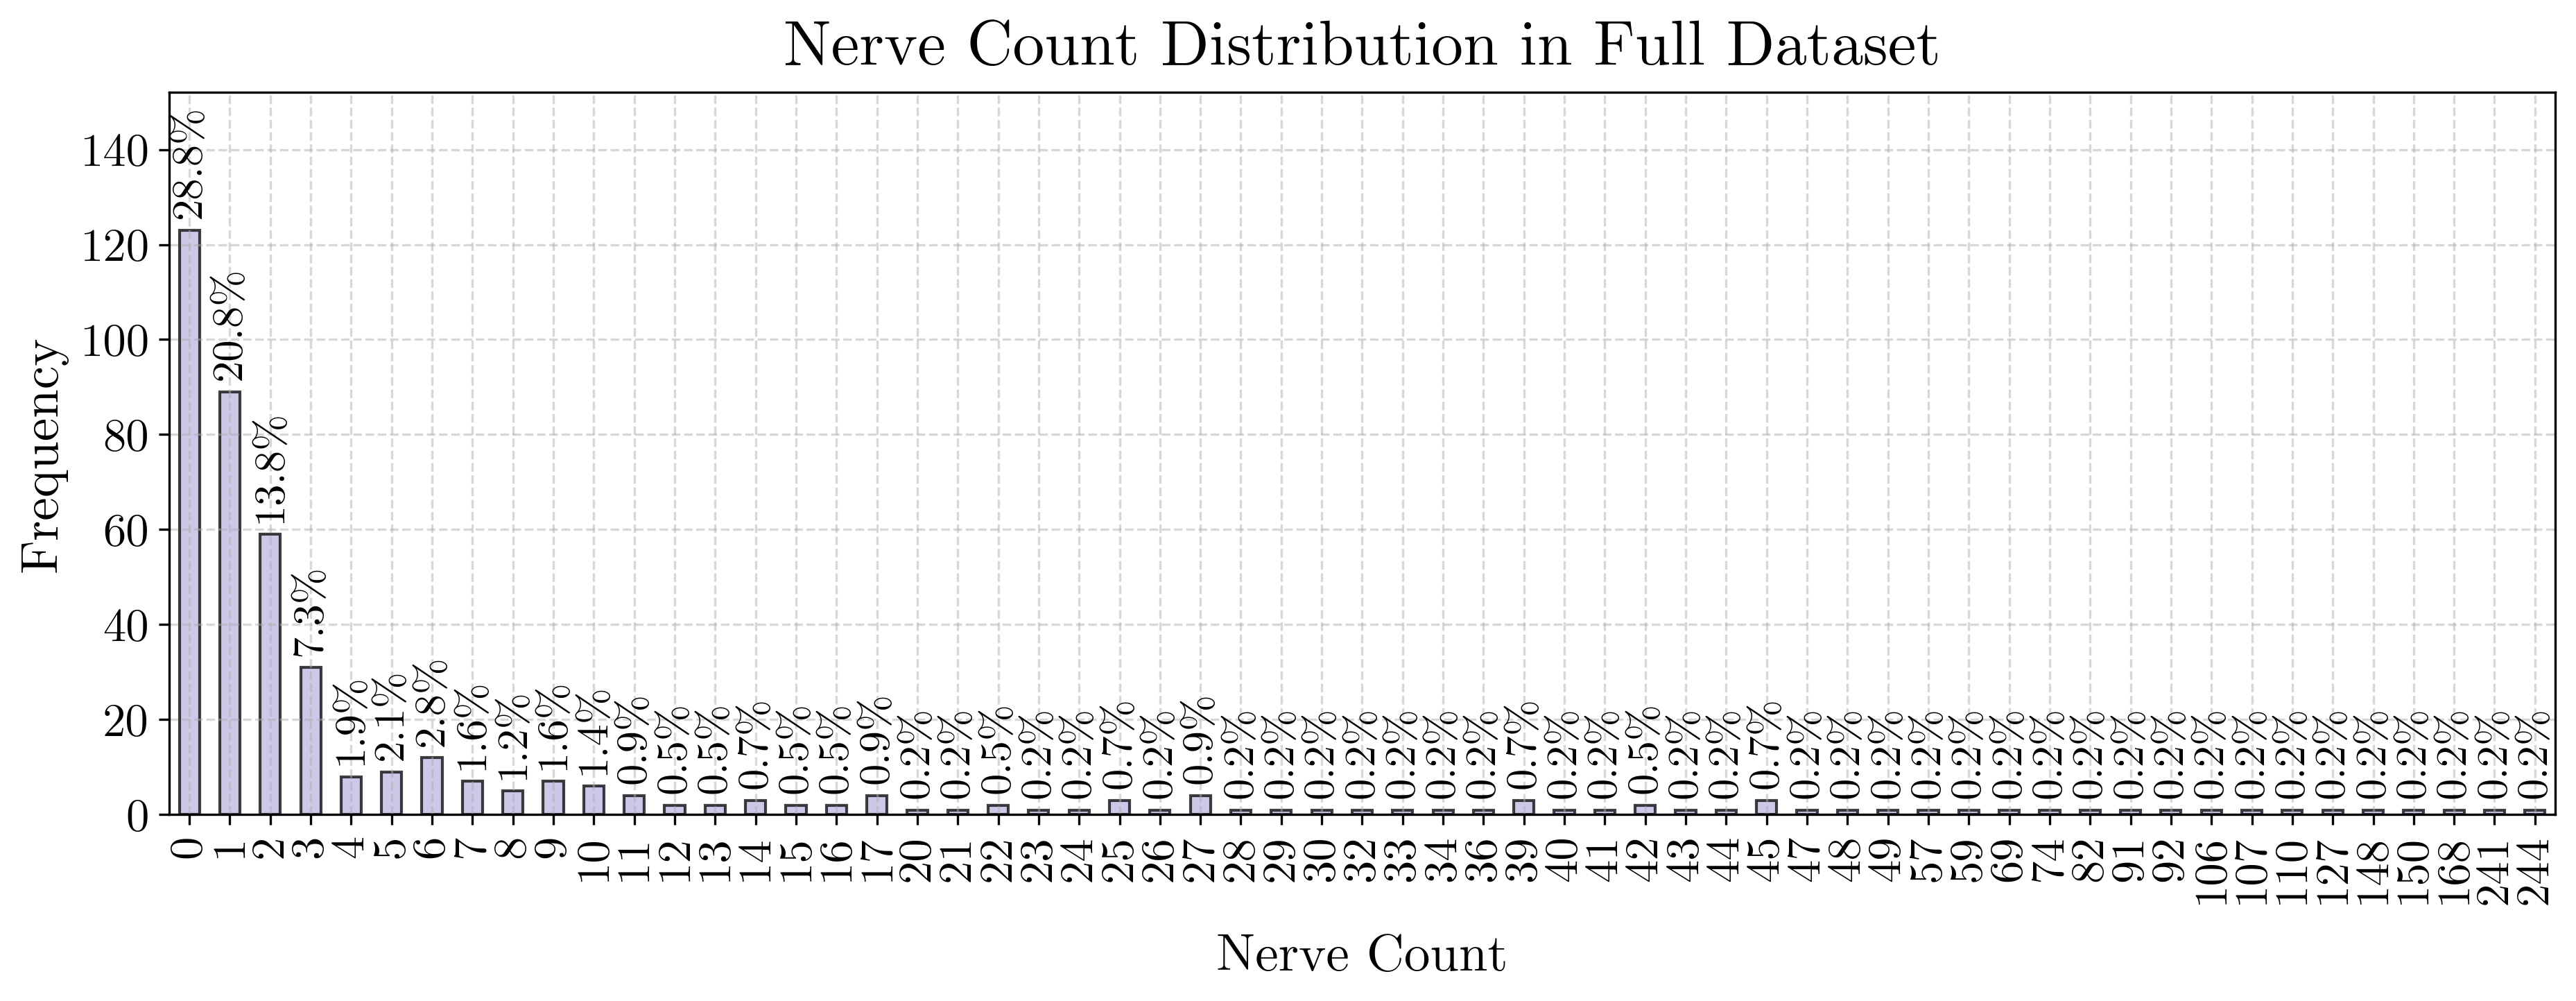

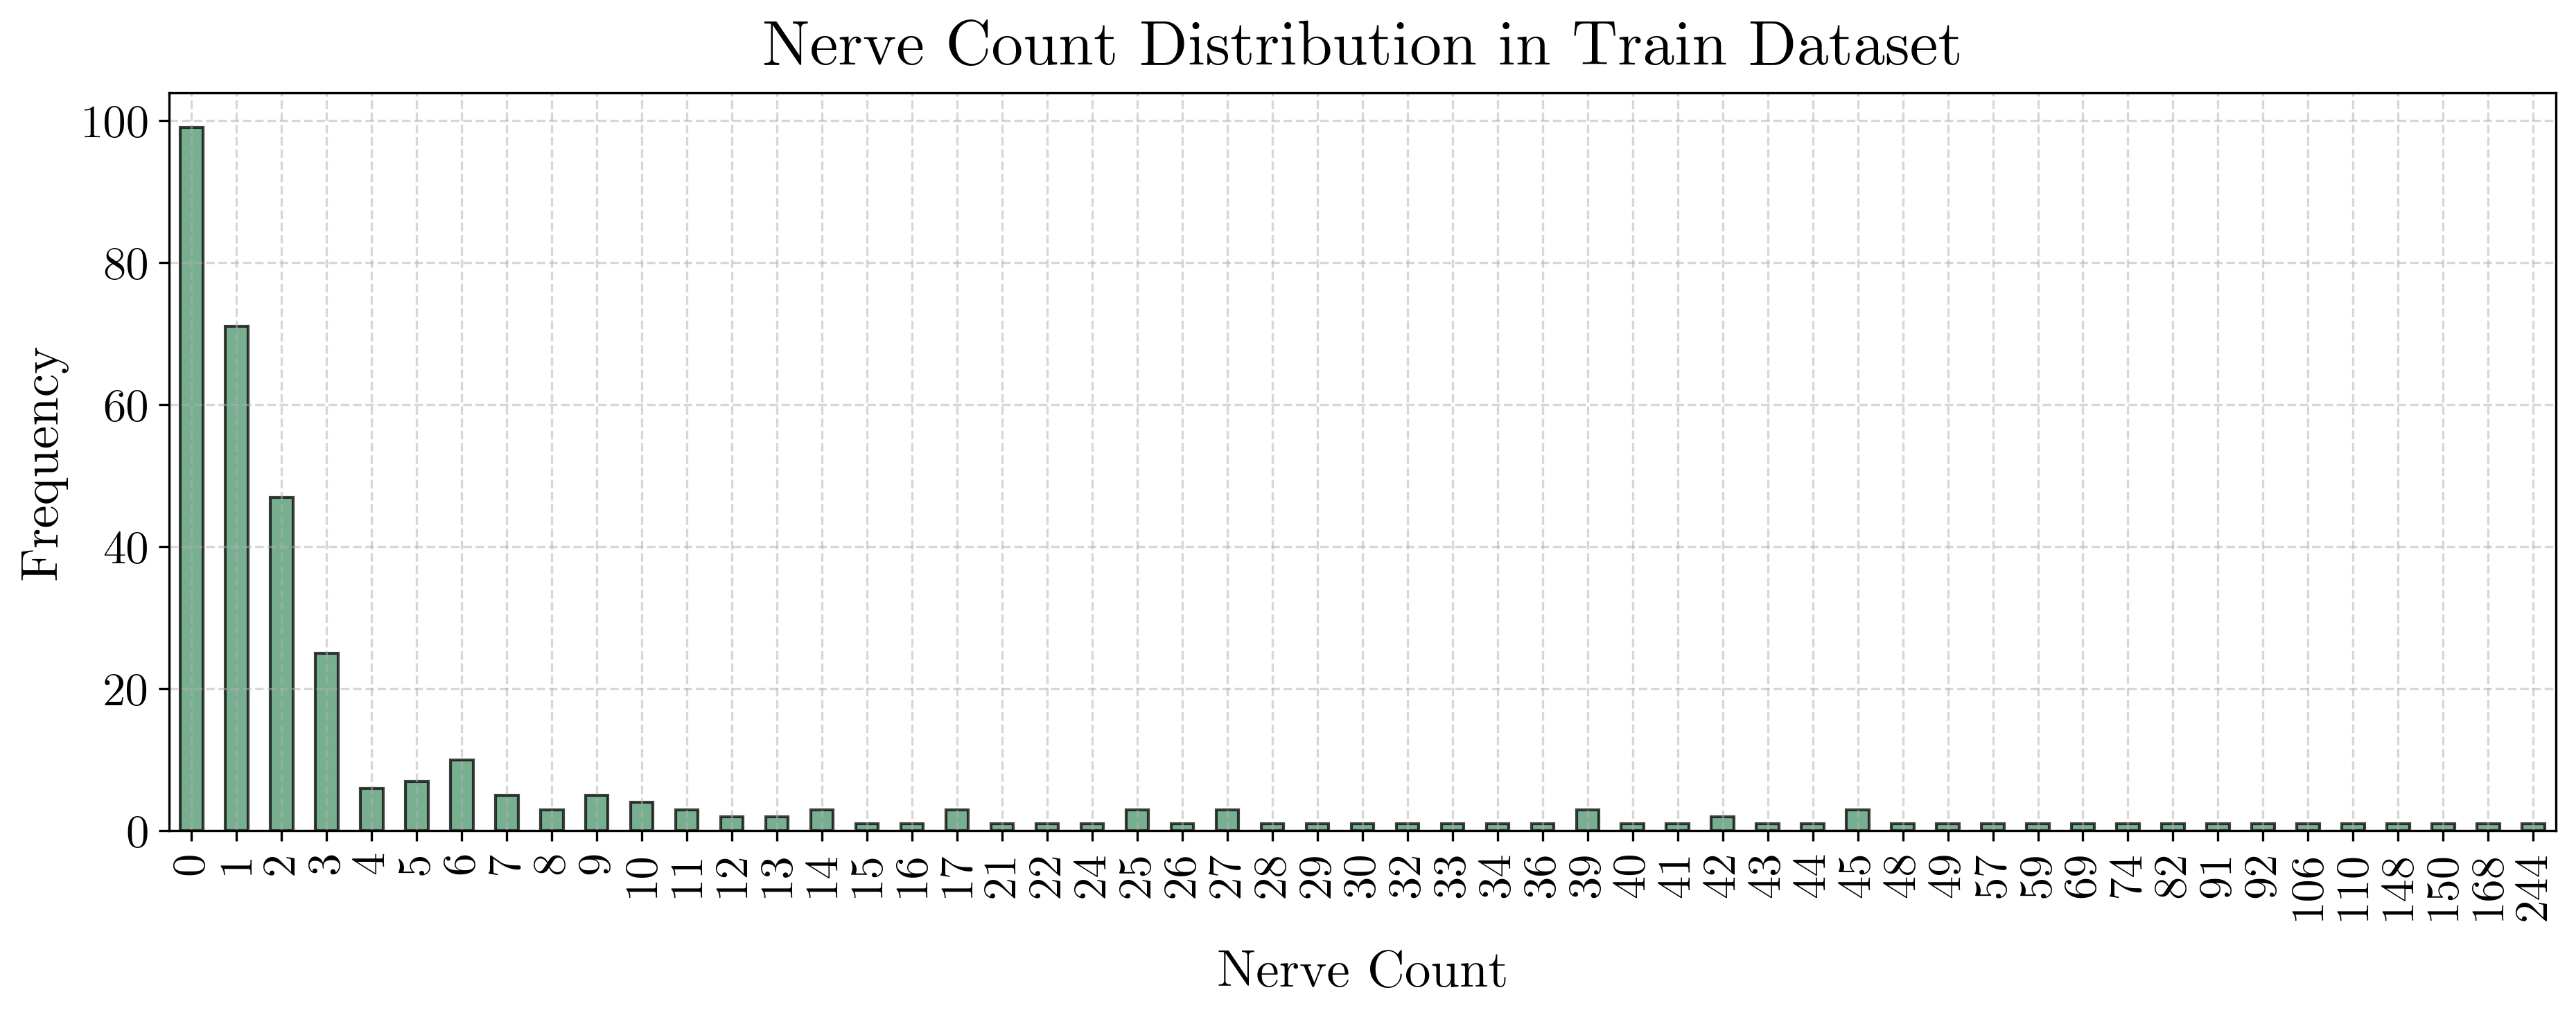

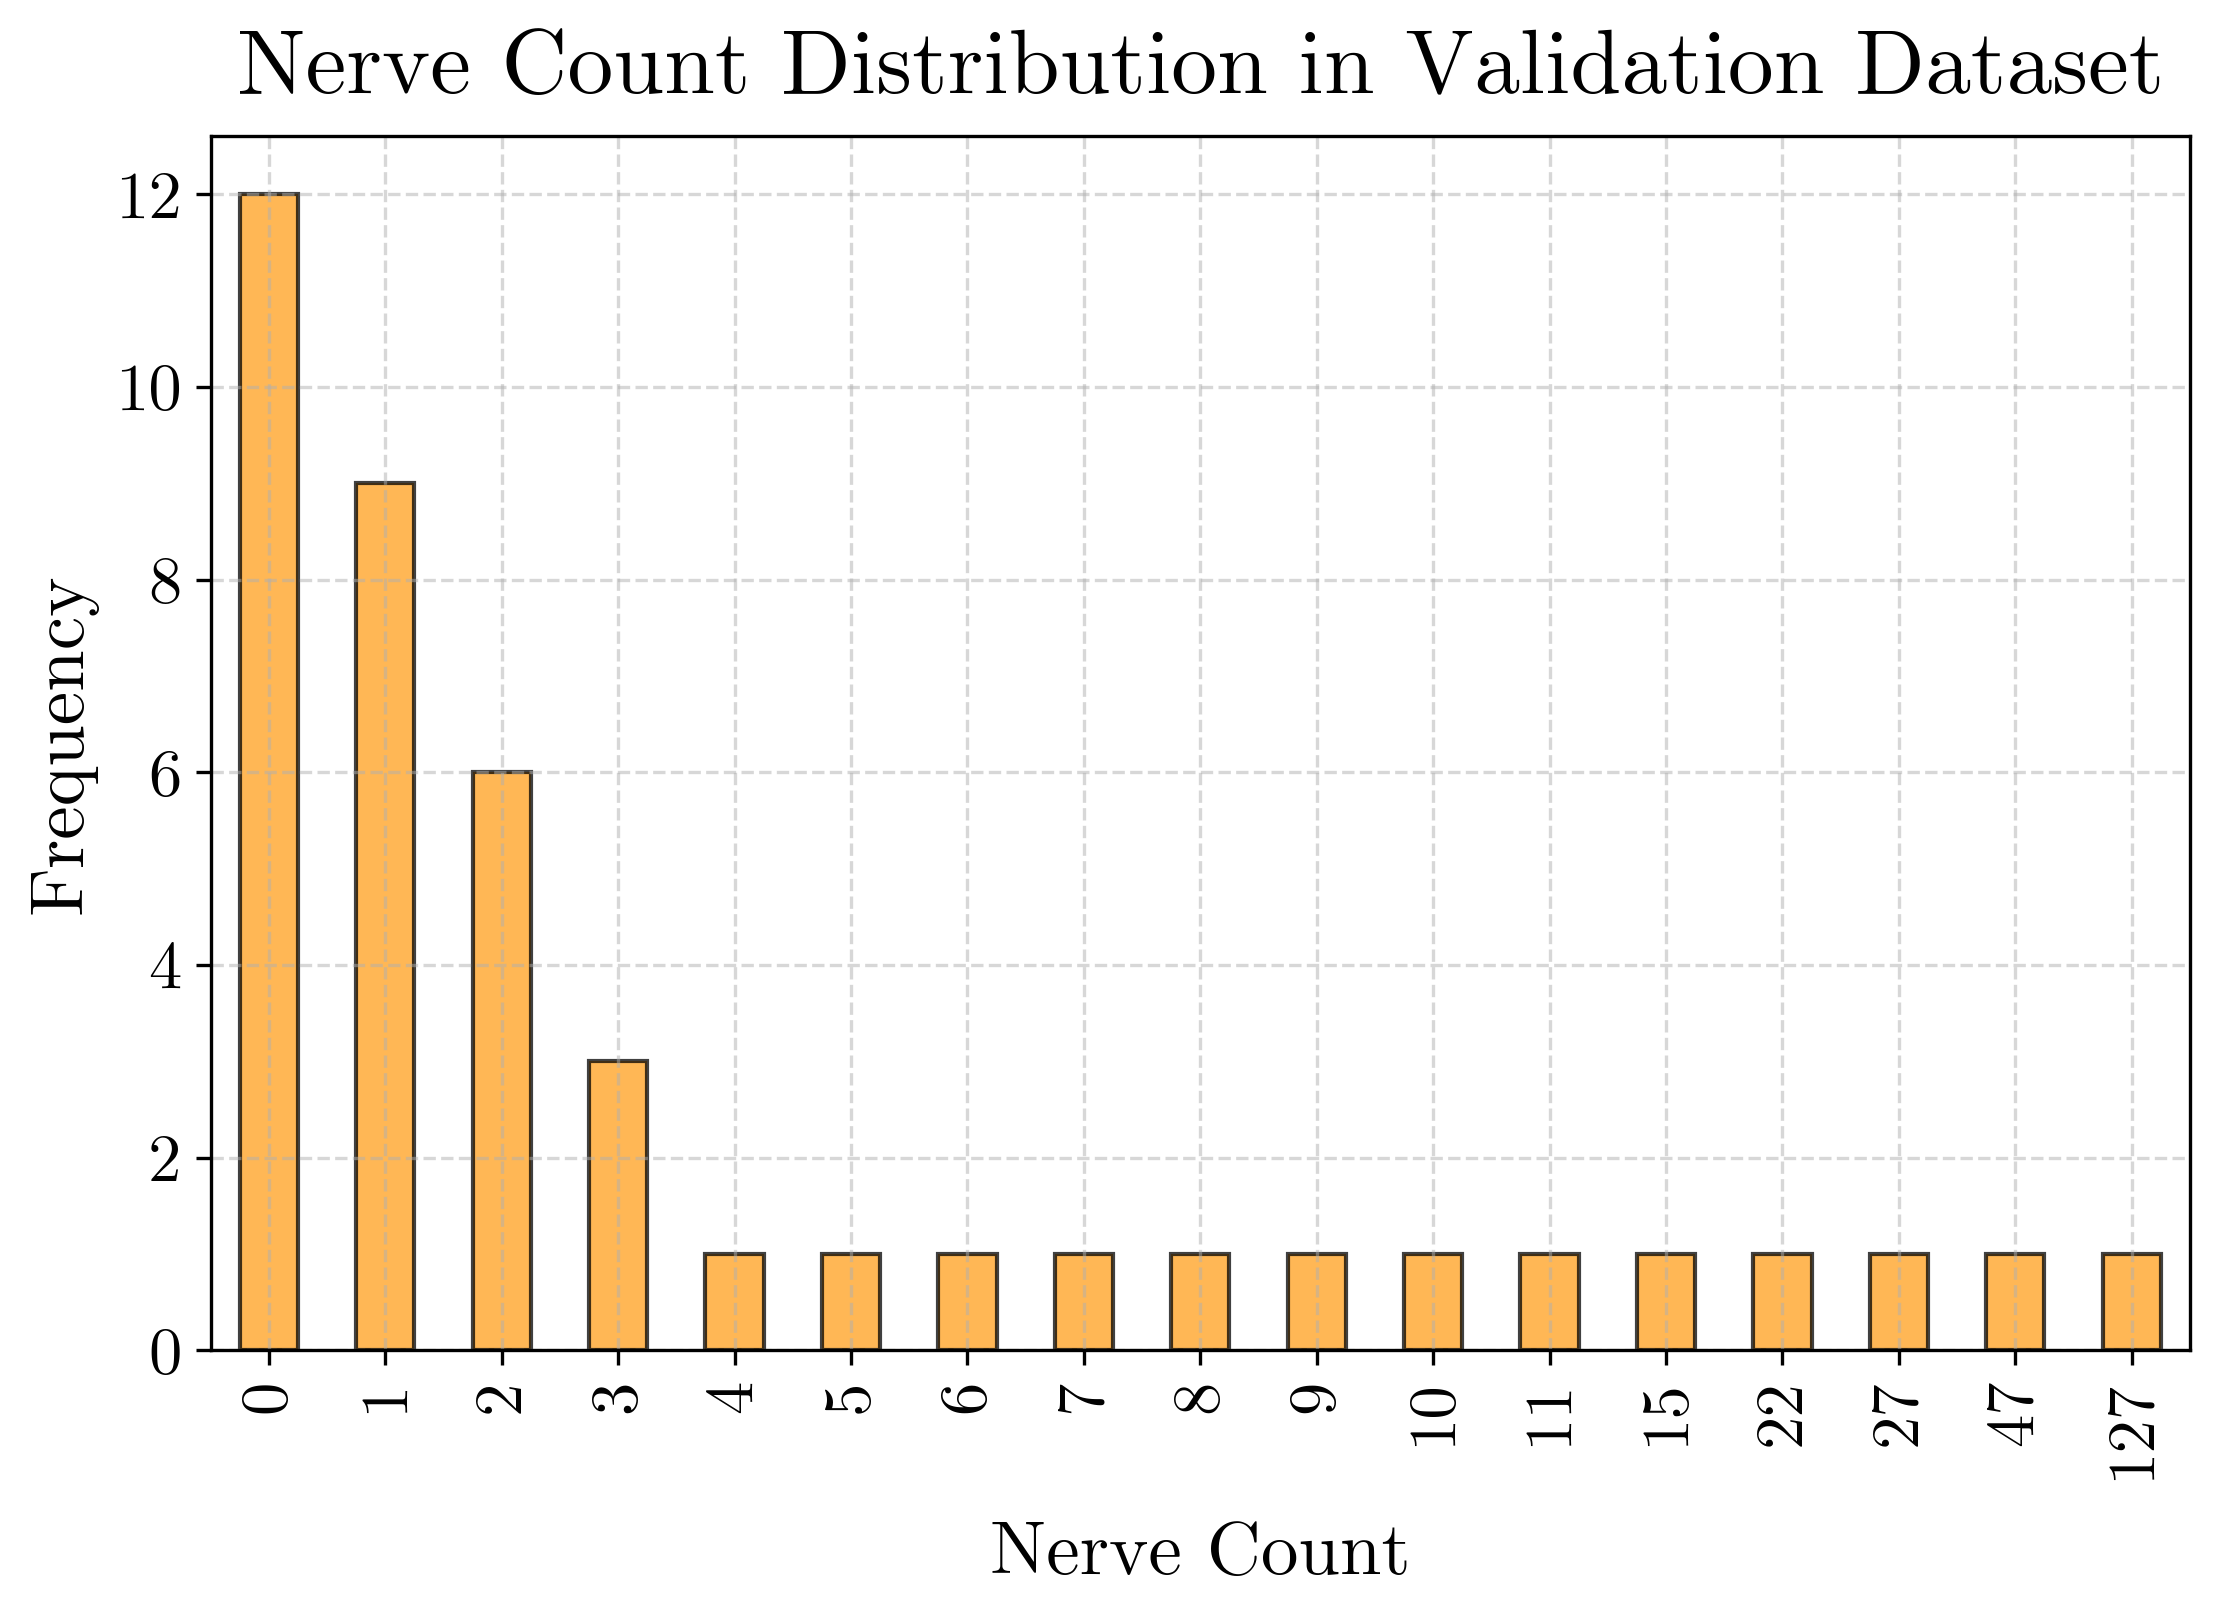

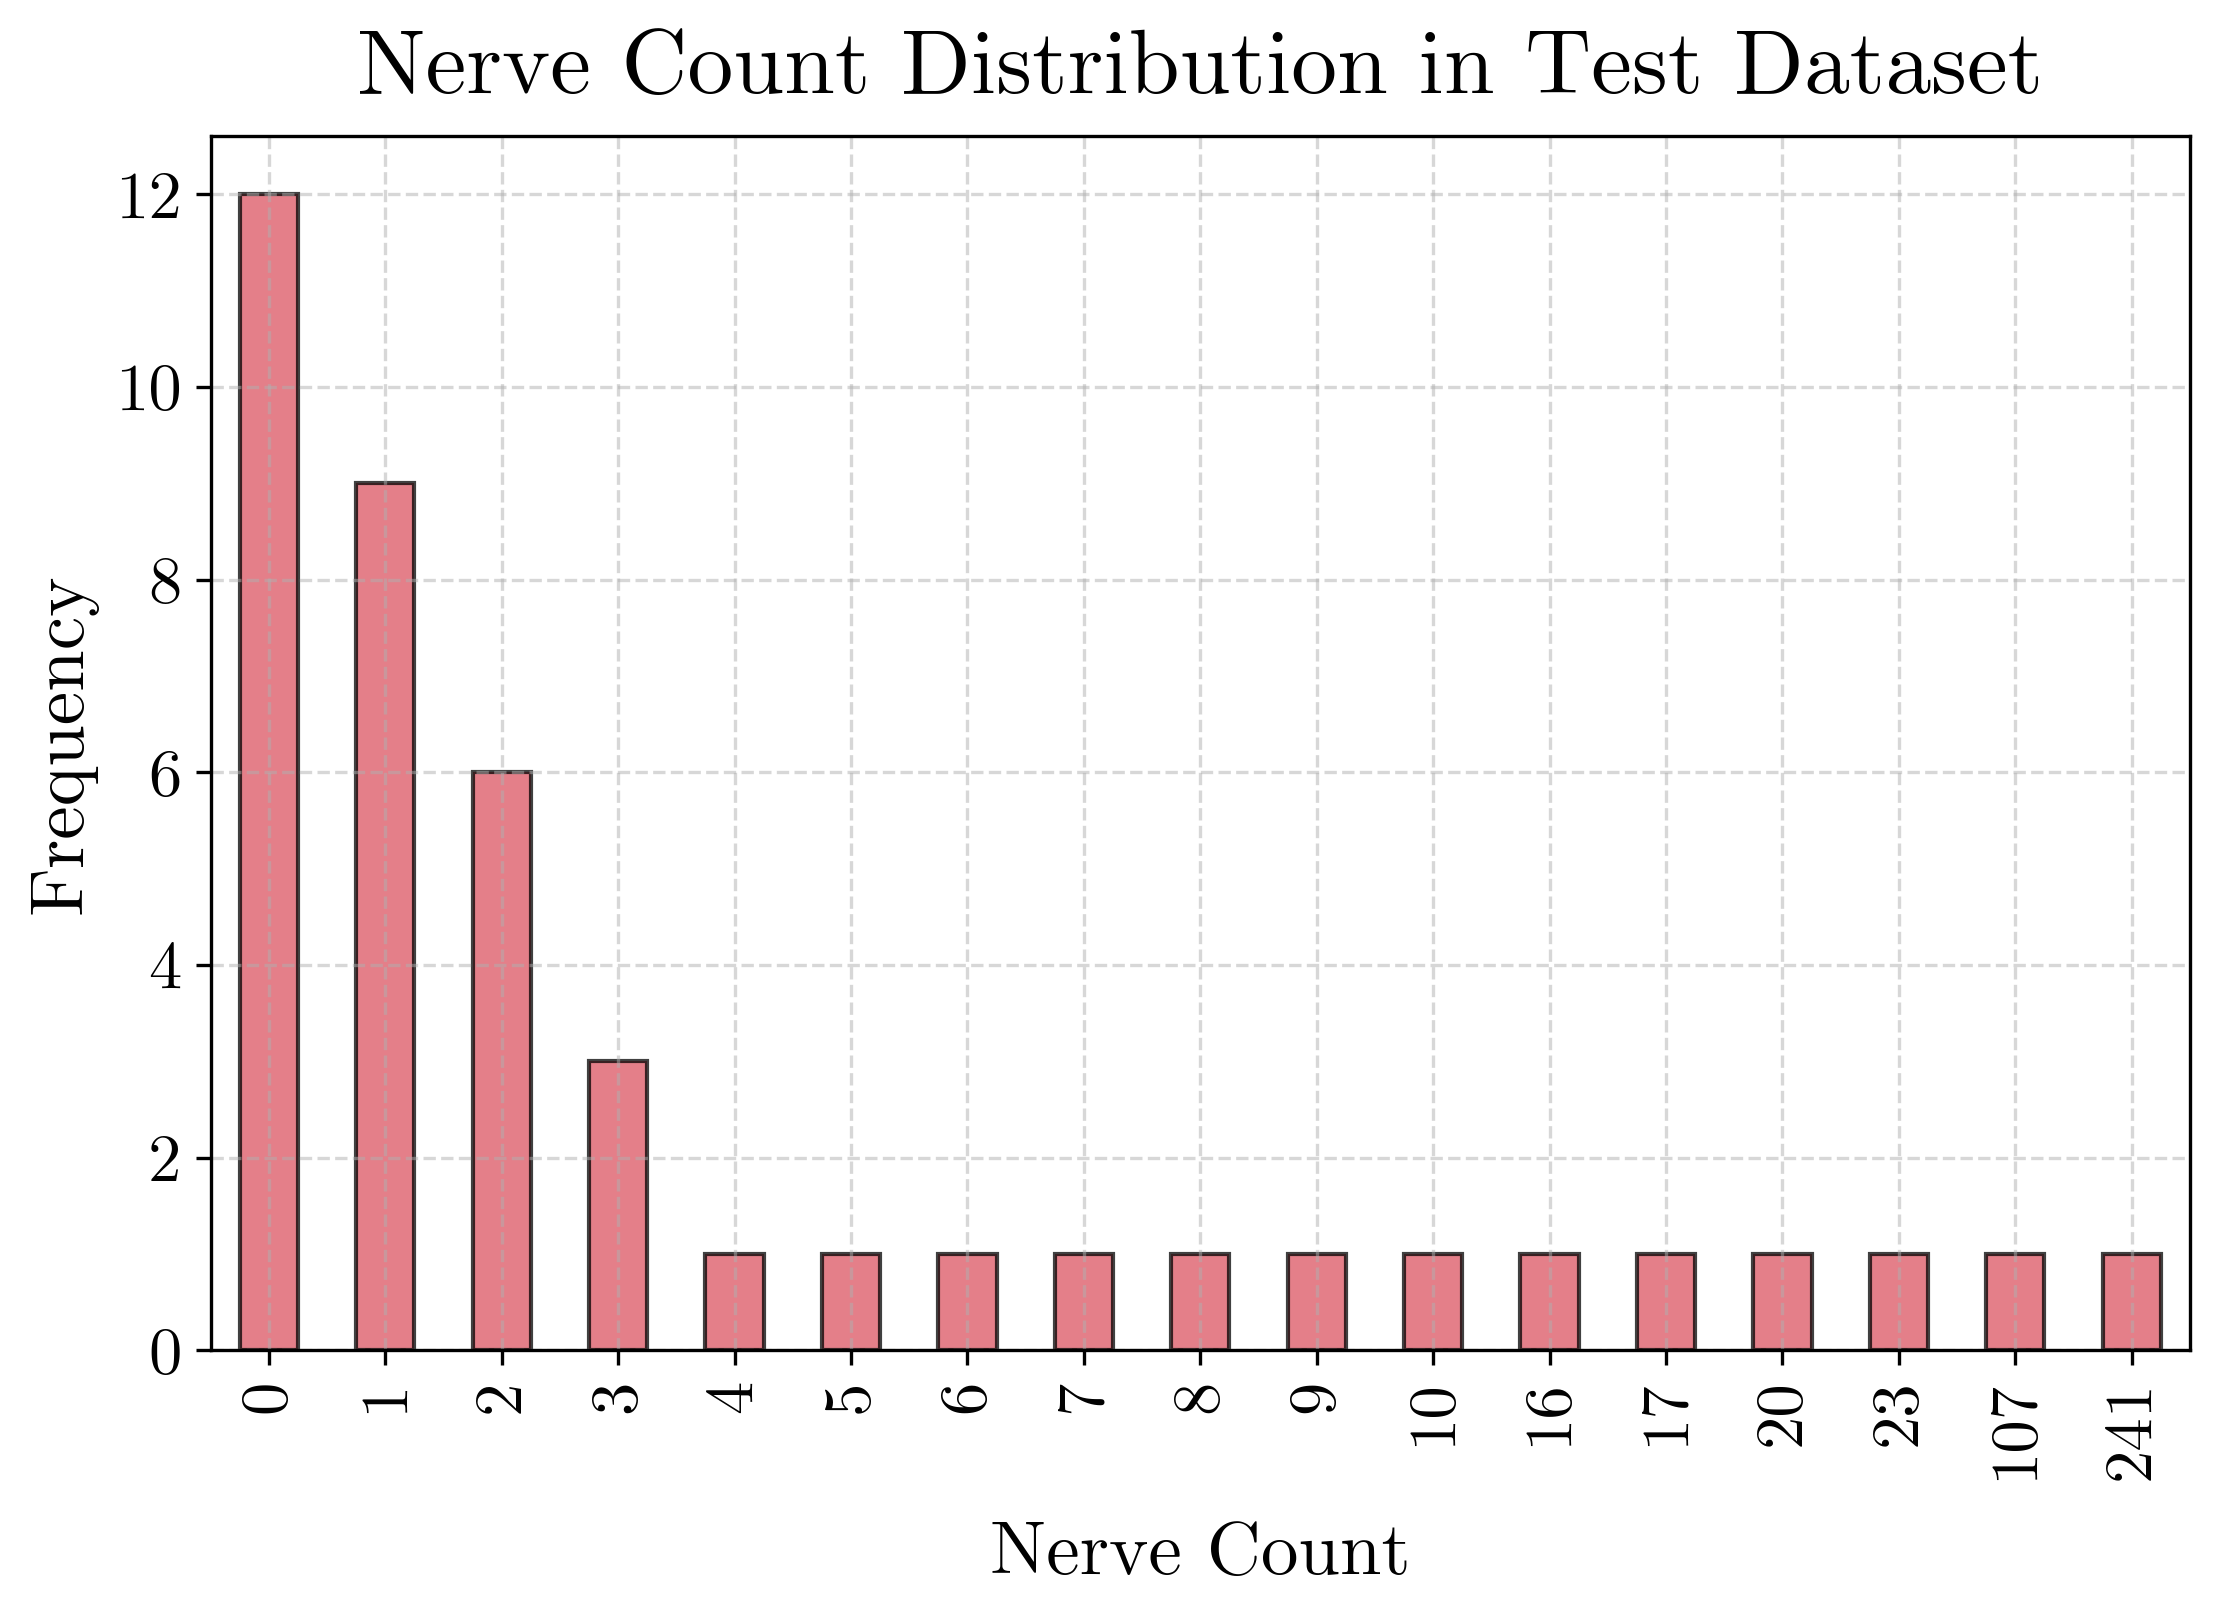

In [8]:
cmu_font = font_manager.FontProperties(fname="cmu.serif-roman.ttf")
colors = ["#BBB6DF", "#4C956C", "#FF9F1C", "#DB5461"]

for (dataset, counts), color in zip(dataset_names.items(), colors):
    counts = counts.sort_index()

    total = counts.sum()

    if dataset == "Full" or dataset == "Train":
        plt.figure(figsize=(12.5, 5), dpi=300)
    if dataset == "Validation" or dataset == "Test":
        plt.figure(figsize=(7.5, 5.5), dpi=300)
    bars = counts.plot(kind='bar', color=color, edgecolor='black', alpha=0.75)

    if dataset == "Full":
        # Add annotations on top of bars
        for bar in bars.patches:
            height = bar.get_height()
            if height > 0:
                percentage = (height / total) * 100
                plt.text(bar.get_x() + bar.get_width() / 2, height + 2.5, f'{percentage:.1f}%',
                         ha="center", va="bottom", rotation=90, fontproperties=cmu_font, fontsize=15)

    plt.title(f'Nerve Count Distribution in {dataset} Dataset', fontproperties=cmu_font, fontsize=22, y=1.015)
    plt.xlabel('Nerve Count', fontproperties=cmu_font, fontsize=18, labelpad=10)
    plt.ylabel('Frequency', fontproperties=cmu_font, fontsize=18)
    plt.xticks(rotation=90, fontproperties=cmu_font, fontsize=16)
    plt.yticks(fontproperties=cmu_font, fontsize=16)
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    if dataset == "Full":
        plt.ylim(0, 152)

    plt.show()